# 1. KNN Imputation of Missing Values in Raw Data

#### Start Here

This is the first step in this tool. This Jupyter Notebook file uses KNN imputation to resolve missing values in tidy datasets. Import the following packages and functions to start.

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
pd.options.display.max_rows=10
pd.options.display.max_columns=6

In [69]:
class KNN_impute:

    '''    
        INIT FUNCTION: 
        
        --Input csv file with raw data. Specify "IDs" -- any columns not to be scaled.
        
        --In the sample data, for example, the "IDs" are the ID column and the outcome variable column.
        
        --Output from this function includes a dataframe of only specified IDs and a dataframe of all other columns.
    '''
    
    def __init__(self, datafile, IDs = []):
        self.data = pd.read_csv(datafile)
        self.IDs = IDs
        self.IDdf = self.data.filter(IDs)
        self.nonIDdf = pd.DataFrame(self.data.drop(self.IDs, axis=1))

    '''
        SCALE METHOD: 
        
        --Specify which scaler to use and input a csv filename to export the dataframe with the scaled data and IDs columns.
    ''' 
    
    def scale (self, scaler, csvname):
        self.scaler = scaler
        self.scaled_data = pd.DataFrame(self.scaler.fit_transform(self.nonIDdf), columns=self.nonIDdf.columns)
        self.combine_dfs = [self.IDdf, self.scaled_data]
        self.scaled_data_with_IDs = pd.concat(self.combine_dfs, axis=1)
        self.scaled_data_with_IDs.to_csv(csvname, index=False)
        
    '''
        IMPUTE METHOD:
        
        --Specify which imputer to use.
    '''    
    
    def impute (self, imputer):
        self.imputer = imputer
        self.imputed_data = self.imputer.fit_transform(self.scaled_data_with_IDs)
        self.output_df = pd.DataFrame(self.imputed_data, columns=self.scaled_data_with_IDs.columns)
        
    '''
        UNIQUE_VIZ METHOD:
        
        --Specify csv name to export the number of unique values per column after imputation.
        
        --Specify size for visualization of unique values per feature.
        
        --These data and this visualization will tell us which columns have insufficient variance for further analysis.
    '''
        
    def unique_viz (self, csvname, figsize=[]):
        self.unique = pd.DataFrame(self.output_df.drop(self.IDs, axis=1).nunique(axis=0))
        self.unique.columns = ["num_unique"]
        self.unique.index.name = 'feature'
        self.cutpoint_plot = self.unique.plot.line(figsize=figsize)
        self.unique.to_csv(csvname, index=True)
        
    '''
        FILTERCOLS METHOD:
        
        --Removes columns with insufficient variance according to specified cutpoint.
        
        --Specify csvname for final output dataframe with imputed values.
    '''
    
    def filterCols (self, cutpoint, csvname):
        self.new_df = self.output_df
        for col in self.output_df.drop(self.IDs, axis=1).columns:
            if len(self.output_df[col].unique()) < cutpoint:
                self.new_df = self.new_df.drop(col,axis=1)
        self.new_df.to_csv(csvname, index=False)
        self.final_df = pd.DataFrame(self.new_df)

In [70]:
class FullJoin:
    
    '''
        --This class combines multiple tidy dataframes.
    '''
    
    def __init__(self, csvname, dflist = []):
        self.dflist = dflist
        self.fulldf = pd.concat(self.dflist, axis=1)
        self.fulldf = self.fulldf.loc[:,~self.fulldf.columns.duplicated()]
        self.fulldf.to_csv(csvname, index=False)

#### KNN Imputation of Missing Values in Yaw Data

Raw sample data are split into six csv files because the different 6DOF dimensions have different ranges of values, so it is necessary to scale them separately. We will start with the data for yaw.

     labvisitid  presence   yaw_0.5  ...  yaw_461.5  yaw_462  yaw_462.5
0           1.0       4.0  0.424407  ...        0.0      0.0        0.0
1           2.0       3.2  0.419289  ...        0.0      0.0        0.0
2           3.0       3.4  0.476286  ...        0.0      0.0        0.0
3           4.0       2.8  0.511884  ...        0.0      0.0        0.0
4           5.0       3.4  0.474331  ...        0.0      0.0        0.0
..          ...       ...       ...  ...        ...      ...        ...
211       259.0       2.8  0.498104  ...        0.0      0.0        0.0
212       260.0       3.4  0.526236  ...        0.0      0.0        0.0
213       261.0       4.0  0.488090  ...        0.0      0.0        0.0
214       262.0       4.8  0.322758  ...        0.0      0.0        0.0
215       263.0       4.4  0.543669  ...        0.0      0.0        0.0

[216 rows x 927 columns]


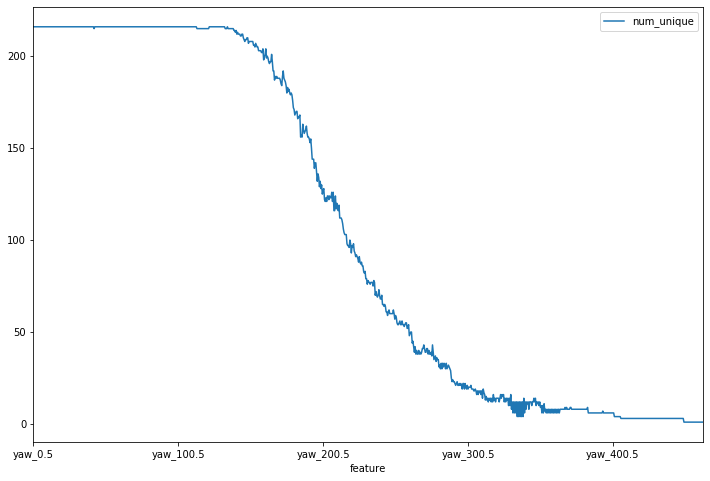

In [87]:
#Read in csv of yaw values
#Create KNN_impute class object "yaw"
#ID column and presence outcome column are specified not to be scaled.
yaw = KNN_impute("Data_Yaw.csv", IDs = ['labvisitid', 'presence'])

#We will use MinMaxScaler() to scale the data since these data are not normally distributed.
yaw.scale(MinMaxScaler(), "yaw_scaled.csv")

#We will use KNNImputer() on the sample data.
yaw.impute(KNNImputer(n_neighbors=3))

print(yaw.output_df)

yaw.unique_viz("yaw_unique.csv", figsize=(12,8))

#This plot will allow us to decide where to truncate the data to remove columns with low variance.
yawline = yaw.cutpoint_plot

We can see that the number of unique values per feature decreases as we move along the dataset. For example, yaw_100.5 (the feature representing users' yaw value at 100.5 seconds into VR use) contains roughly 216 unique values, the same as our number of participants. By yaw_300.5, the number of unique values per feature is roughly a tenth of the number of participants. These columns will likely not have sufficient variance to be useful in our future analyses.

Why is this graph shaped this way for the sample data? Since the dataset must contain enough columns to record data for the participant spending the longest amount of time in the VR environment, each participant's row of data only has values until the half-second they exit VR. Any columns to the right of that have no data and are marked as missing. Near the right side of the data file, the imputer only has a couple real data points per column to impute from, so most participants have received the same couple of values in those columns. The number of unique values per column, as seen in this graph, is roughly approximated by the number of participants still in VR at that half-second.

Below, I have chosen to truncate the yaw data so that only columns with 30 or more unique values are retained. I chose this value because it corresponds with a distinct drop in the graph, so that all half-seconds up to a certain point are included and no half-seconds after that point are included. As it turns out, this cutpoint of 30 worked in a similar way for all 6 degrees of freedom; for each of the 6DOF, setting a cutpoint of 30 unique values resulted in a dataset which records from 0.5 seconds to 288 +/- 0.5 seconds.

In [72]:
yaw.filterCols(30, "yaw_imputed.csv")
yaw.final_df

,labvisitid,presence,yaw_0.5,...,yaw_287,yaw_287.5,yaw_288
0,1.0,4.0,0.424407,...,0.289145,0.294373,0.306312
1,2.0,3.2,0.419289,...,0.289145,0.294373,0.306312
2,3.0,3.4,0.476286,...,0.289145,0.294373,0.306312
3,4.0,2.8,0.511884,...,0.289145,0.294373,0.306312
4,5.0,3.4,0.474331,...,0.289145,0.294373,0.306312
...,...,...,...,...,...,...,...
211,259.0,2.8,0.498104,...,0.404961,0.404995,0.420951
212,260.0,3.4,0.526236,...,0.404961,0.404995,0.420951
213,261.0,4.0,0.488090,...,0.404961,0.404995,0.420951
214,262.0,4.8,0.322758,...,0.404961,0.404995,0.420951


#### KNN Imputation of Missing Values in Pitch Data

The same procedure used to impute values for missing yaw data can be applied with no notable differences to the pitch, roll, x, y, and z data.

     labvisitid  presence  pitch_0.5  ...  pitch_461.5  pitch_462  pitch_462.5
0           1.0       4.0   0.548471  ...          0.0        0.0          0.0
1           2.0       3.2   0.288129  ...          0.0        0.0          0.0
2           3.0       3.4   0.139014  ...          0.0        0.0          0.0
3           4.0       2.8   0.659744  ...          0.0        0.0          0.0
4           5.0       3.4   0.087555  ...          0.0        0.0          0.0
..          ...       ...        ...  ...          ...        ...          ...
211       259.0       2.8   0.232430  ...          0.0        0.0          0.0
212       260.0       3.4   0.187118  ...          0.0        0.0          0.0
213       261.0       4.0   0.178444  ...          0.0        0.0          0.0
214       262.0       4.8   0.394587  ...          0.0        0.0          0.0
215       263.0       4.4   0.093992  ...          0.0        0.0          0.0

[216 rows x 927 columns]


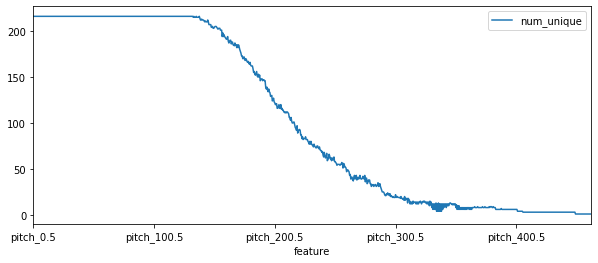

In [73]:
pitch = KNN_impute("Data_Pitch.csv", IDs = ['labvisitid', 'presence'])
pitch.scale(MinMaxScaler(), "pitch_scaled.csv")
pitch.impute(KNNImputer(n_neighbors=3))
pitch_all = pd.DataFrame(pitch.output_df)
print(pitch_all)
pitch.unique_viz("pitch_unique.csv", figsize=(10,4))
pitchline = pitch.cutpoint_plot

In [74]:
pitch.filterCols(30, "pitch_imputed.csv")

#### KNN Imputation of Missing Values in Roll Data

     labvisitid  presence  roll_0.5  ...  roll_461.5  roll_462  roll_462.5
0           1.0       4.0  0.654311  ...         0.0       0.0         0.0
1           2.0       3.2  0.379595  ...         0.0       0.0         0.0
2           3.0       3.4  0.468124  ...         0.0       0.0         0.0
3           4.0       2.8  0.522523  ...         0.0       0.0         0.0
4           5.0       3.4  0.468145  ...         0.0       0.0         0.0
..          ...       ...       ...  ...         ...       ...         ...
211       259.0       2.8  0.660400  ...         0.0       0.0         0.0
212       260.0       3.4  0.563272  ...         0.0       0.0         0.0
213       261.0       4.0  0.625336  ...         0.0       0.0         0.0
214       262.0       4.8  0.545936  ...         0.0       0.0         0.0
215       263.0       4.4  0.489715  ...         0.0       0.0         0.0

[216 rows x 927 columns]


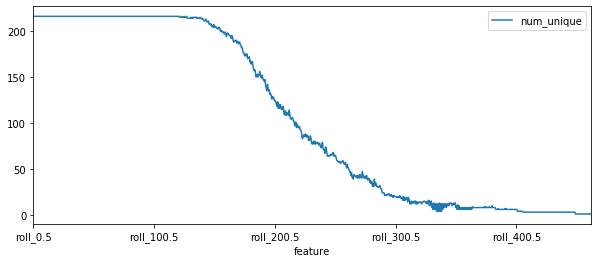

In [75]:
roll = KNN_impute("Data_Roll.csv", IDs = ['labvisitid', 'presence'])
roll.scale(MinMaxScaler(), "roll_scaled.csv")
roll.impute(KNNImputer(n_neighbors=3))
roll_all = pd.DataFrame(roll.output_df)
print(roll_all)
roll.unique_viz("roll_unique.csv", figsize=(10,4))
rollline = roll.cutpoint_plot

In [76]:
roll.filterCols(30, "roll_imputed.csv")

#### KNN Imputation of Missing Values in X-Axis Data

     labvisitid  presence     x_0.5  ...  x_461.5  x_462  x_462.5
0           1.0       4.0  0.263141  ...      0.0    0.0      0.0
1           2.0       3.2  0.405601  ...      0.0    0.0      0.0
2           3.0       3.4  0.351221  ...      0.0    0.0      0.0
3           4.0       2.8  0.285647  ...      0.0    0.0      0.0
4           5.0       3.4  0.404023  ...      0.0    0.0      0.0
..          ...       ...       ...  ...      ...    ...      ...
211       259.0       2.8  0.249609  ...      0.0    0.0      0.0
212       260.0       3.4  0.185196  ...      0.0    0.0      0.0
213       261.0       4.0  0.446995  ...      0.0    0.0      0.0
214       262.0       4.8  0.106594  ...      0.0    0.0      0.0
215       263.0       4.4  0.354316  ...      0.0    0.0      0.0

[216 rows x 927 columns]


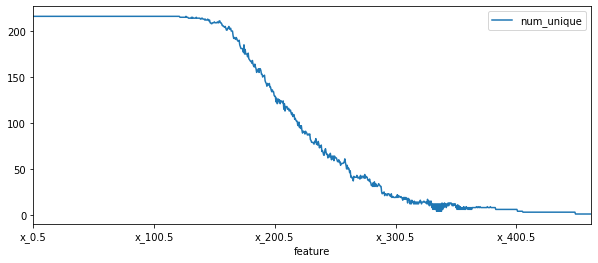

In [77]:
x = KNN_impute("Data_X.csv", IDs = ['labvisitid', 'presence'])
x.scale(MinMaxScaler(), "x_scaled.csv")
x.impute(KNNImputer(n_neighbors=3))
x_all = pd.DataFrame(x.output_df)
print(x_all)
x.unique_viz("x_unique.csv", figsize=(10,4))
xline = x.cutpoint_plot

In [78]:
x.filterCols(30, "x_imputed.csv")

#### KNN Imputation of Missing Values in Y-Axis Data

     labvisitid  presence     y_0.5  ...  y_461.5  y_462  y_462.5
0           1.0       4.0  0.428549  ...      0.0    0.0      0.0
1           2.0       3.2  0.537047  ...      0.0    0.0      0.0
2           3.0       3.4  0.557278  ...      0.0    0.0      0.0
3           4.0       2.8  0.342932  ...      0.0    0.0      0.0
4           5.0       3.4  0.548548  ...      0.0    0.0      0.0
..          ...       ...       ...  ...      ...    ...      ...
211       259.0       2.8  0.316860  ...      0.0    0.0      0.0
212       260.0       3.4  0.454712  ...      0.0    0.0      0.0
213       261.0       4.0  0.910611  ...      0.0    0.0      0.0
214       262.0       4.8  0.428715  ...      0.0    0.0      0.0
215       263.0       4.4  0.366374  ...      0.0    0.0      0.0

[216 rows x 927 columns]


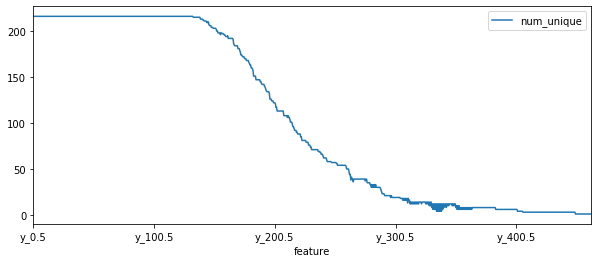

In [79]:
y = KNN_impute("Data_Y.csv", IDs = ['labvisitid', 'presence'])
y.scale(MinMaxScaler(), "y_scaled.csv")
y.impute(KNNImputer(n_neighbors=3))
y_all = pd.DataFrame(y.output_df)
print(y_all)
y.unique_viz("y_unique.csv", figsize=(10,4))
yline = y.cutpoint_plot

In [80]:
y.filterCols(30, "y_imputed.csv")

#### KNN Imputation of Missing Values in Z-Axis Data

     labvisitid  presence     z_0.5  ...  z_461.5  z_462  z_462.5
0           1.0       4.0  0.149444  ...      0.0    0.0      0.0
1           2.0       3.2  0.119485  ...      0.0    0.0      0.0
2           3.0       3.4  0.112860  ...      0.0    0.0      0.0
3           4.0       2.8  0.315297  ...      0.0    0.0      0.0
4           5.0       3.4  0.200984  ...      0.0    0.0      0.0
..          ...       ...       ...  ...      ...    ...      ...
211       259.0       2.8  0.243777  ...      0.0    0.0      0.0
212       260.0       3.4  0.155403  ...      0.0    0.0      0.0
213       261.0       4.0  0.164612  ...      0.0    0.0      0.0
214       262.0       4.8  0.177309  ...      0.0    0.0      0.0
215       263.0       4.4  0.227917  ...      0.0    0.0      0.0

[216 rows x 927 columns]


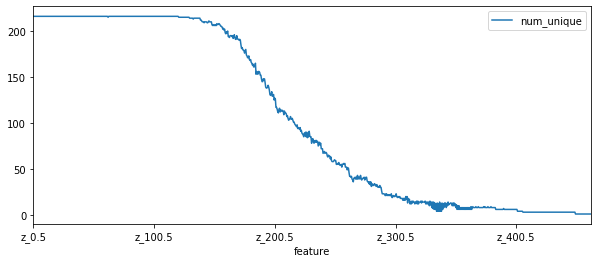

In [81]:
z = KNN_impute("Data_Z.csv", IDs = ['labvisitid', 'presence'])
z.scale(MinMaxScaler(), "z_scaled.csv")
z.impute(KNNImputer(n_neighbors=3))
z_all = pd.DataFrame(z.output_df)
print(z_all)
z.unique_viz("z_unique.csv", figsize=(10,4))
zline = z.cutpoint_plot

In [82]:
z.filterCols(30, "z_imputed.csv")

### Concatenating Data from All Six DataFrames

The final step before we move on to dimensionality reduction is to combine the six scaled and imputed datasets into one csv file that we can read in to the PCA and UMAP code files.

In [83]:
imputed_dfs = FullJoin("SCALED_NONAN_DATA.csv", 
                       dflist=[yaw.final_df, pitch.final_df, roll.final_df, x.final_df, y.final_df, z.final_df])